# Birds Classification project

## By Fabiha Chowdhury and Marjorie Falcon

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications import MobileNetV2

## Load data and exploration

In [6]:
#data_dir = '../Birds/'

data_dir = '/Users/marjoriefalcon/Desktop/Bootcamp DS-22/M3P4-Pretrained_Models-main/Assignments/archive'

os.listdir(data_dir)

['valid', '.DS_Store', 'test', 'train', 'images to predict']

In [8]:
# Explore folder

data_dir = 'archive/'

categories = os.listdir(data_dir)

In [10]:
import glob
import pathlib

# number of images
print(len(list(pathlib.Path(data_dir).glob('*/**/*.jpg'))))

3414


In [12]:
bird_img = data_dir+'/train'+'/ABBOTTS BOOBY'+'/001.jpg'

In [14]:
# image dimentions
imread(bird_img).shape

(224, 224, 3)

In [16]:
# create directory path for each dataset
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
validation_dir = os.path.join(data_dir, 'valid')
predict_dir = os.path.join(data_dir, 'images to predict')

In [18]:
categories = [d.name for d in Path(train_dir).iterdir() if d.is_dir()]
#len(val_categories)

In [20]:
batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)
img_shape = img_size + (3,)

In [22]:
import tensorflow as tf
import tensorflow.keras as keras

# create training dataset
data_train = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3208 files belonging to 20 classes.


In [24]:
data_validation = keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 100 files belonging to 20 classes.


In [26]:
# create test dataset
data_test = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 100 files belonging to 20 classes.


In [28]:
class_names = data_train.class_names
print(class_names)

num_classes = len(class_names)

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL']


## Visualize a sample of the data

2024-11-20 22:40:06.391634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3208]
	 [[{{node Placeholder/_4}}]]
2024-11-20 22:40:06.391921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3208]
	 [[{{node Placeholder/_4}}]]
2024-11-20 22:40:06.397379: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


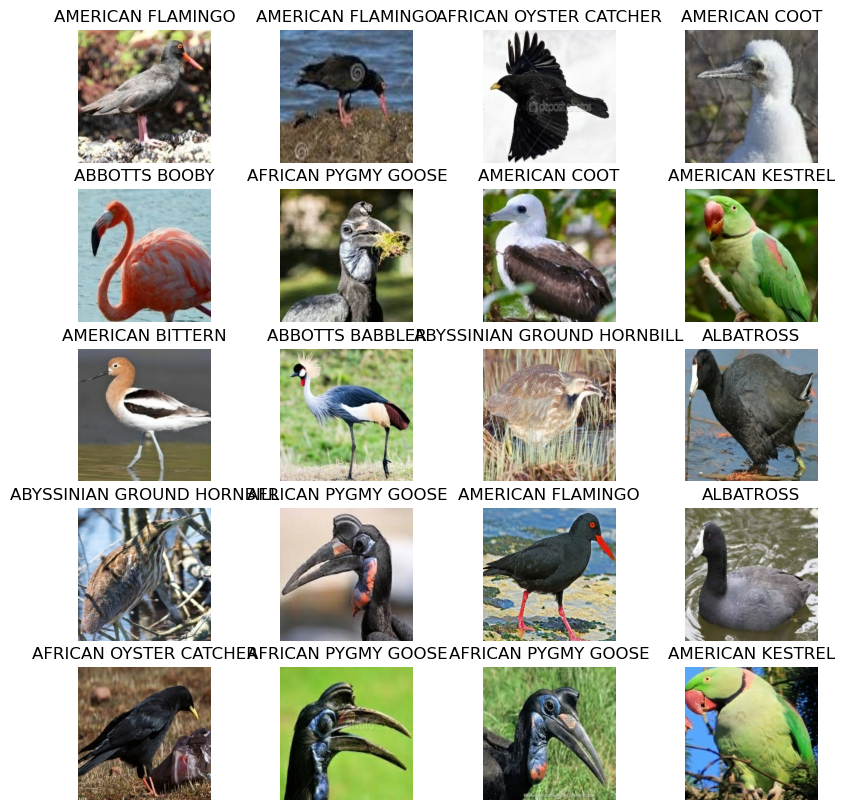

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(categories[labels[i]])
    plt.axis("off")

## Datasets configuration

In [34]:
# Use buffered prefectching to improve performance

# AUTOTUNE = tf.data.AUTOTUNE

# data_train = data_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# data_test = data_test.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
# normalize the data

normalization_layer = layers.Rescaling(1./255)

# testing the normalization layer on the data. However, instead of using the normalized data, the layer will be added to the model
norm_data_train = data_train.map(lambda x, y: (normalization_layer(x), y))
norm_data_test = data_test.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(norm_data_train))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


2024-11-20 22:40:14.631716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3208]
	 [[{{node Placeholder/_4}}]]
2024-11-20 22:40:14.631866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3208]
	 [[{{node Placeholder/_4}}]]


## Build the model

In [39]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

In [41]:
base_model.trainable = False

In [43]:
# create the layers to be included in the model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [51]:
# create the model
model = tf.keras.Sequential([
    normalization_layer,
    base_model,
    global_average_layer,
    prediction_layer
])

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________


In [57]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [59]:
# train the model

epochs=30
history = model.fit(
    data_train,
    validation_data=data_test,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/30


2024-11-20 22:41:01.955608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3208]
	 [[{{node Placeholder/_4}}]]
2024-11-20 22:41:01.955838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3208]
	 [[{{node Placeholder/_4}}]]


100/101 [============================>.] - ETA: 0s - loss: 0.9738 - accuracy: 0.7578

2024-11-20 22:41:15.069755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100]
	 [[{{node Placeholder/_4}}]]
2024-11-20 22:41:15.069881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 14s 129ms/step - loss: 0.9724 - accuracy: 0.7581 - val_loss: 0.2732 - val_accuracy: 0.9700
Epoch 2/30
101/101 [==============================] - 13s 127ms/step - loss: 0.2300 - accuracy: 0.9542 - val_loss: 0.1536 - val_accuracy: 0.9900
Epoch 3/30
101/101 [==============================] - 13s 128ms/step - loss: 0.1394 - accuracy: 0.9732 - val_loss: 0.1179 - val_accuracy: 0.9900
Epoch 4/30
101/101 [==============================] - 13s 133ms/step - loss: 0.0959 - accuracy: 0.9863 - val_loss: 0.0972 - val_accuracy: 0.9900
Epoch 5/30
101/101 [==============================] - 13s 131ms/step - loss: 0.0718 - accuracy: 0.9925 - val_loss: 0.0801 - val_accuracy: 0.9900
Epoch 6/30
101/101 [==============================] - 13s 129ms/step - loss: 0.0547 - accuracy: 0.9953 - val_loss: 0.0765 - val_accuracy: 0.9900
Epoch 7/30
101/101 [==============================] - 13s 129ms/step - loss: 0.0436 - accuracy: 0.9978 - val_loss: 0.0712 - val_accuracy: 0.9

In [61]:
# visualize training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

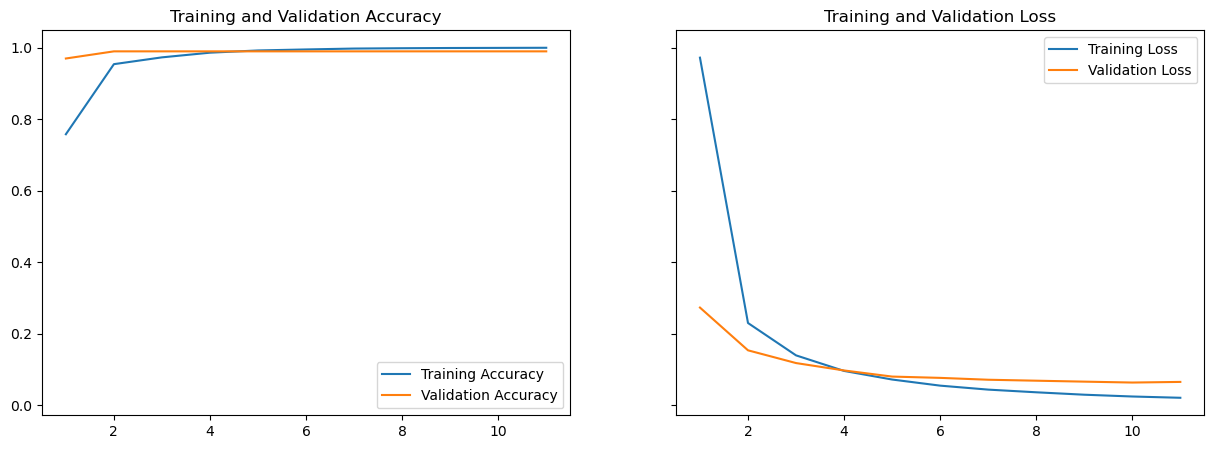

In [67]:
epochs_range = range(1,12)

# Create a multiplot with subplots for each species
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=True)

ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.title.set_text('Training and Validation Accuracy')

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.title.set_text('Training and Validation Loss')
plt.show()

## Predict one new data

In [70]:
img_predict_dir = os.path.join(data_dir, 'images to predict')
images_to_predict = [os.path.join(img_predict_dir, img) for img in os.listdir(img_predict_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]


1/1 [==============================] - 0s 245ms/step


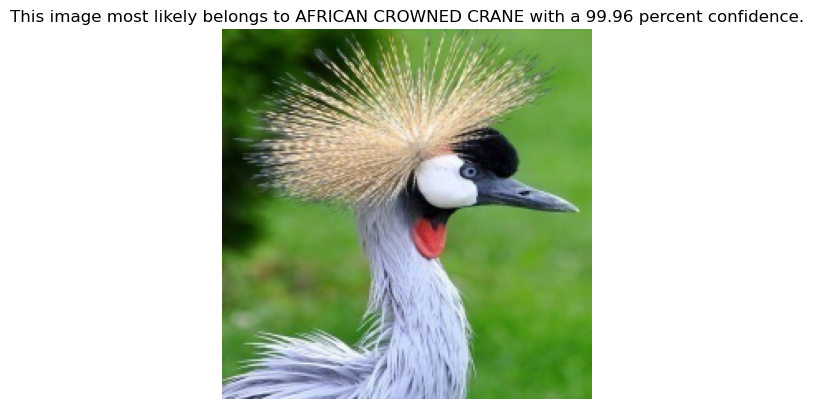

1/1 [==============================] - 0s 22ms/step


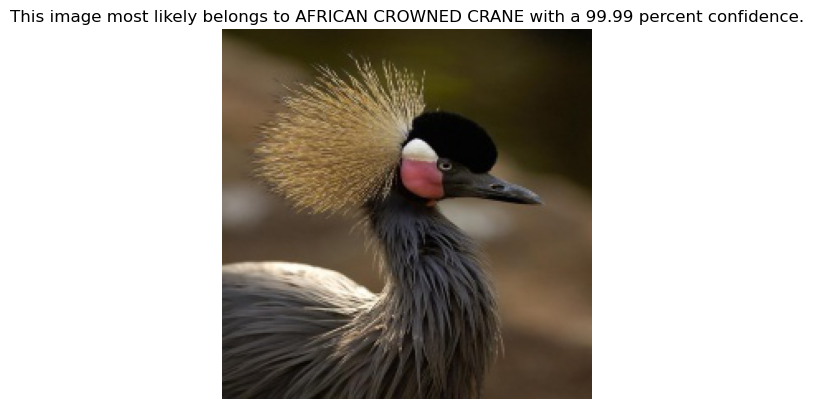

1/1 [==============================] - 0s 23ms/step


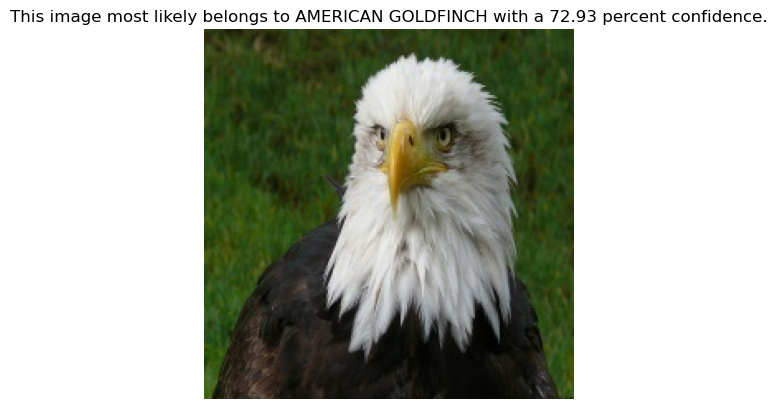

1/1 [==============================] - 0s 23ms/step


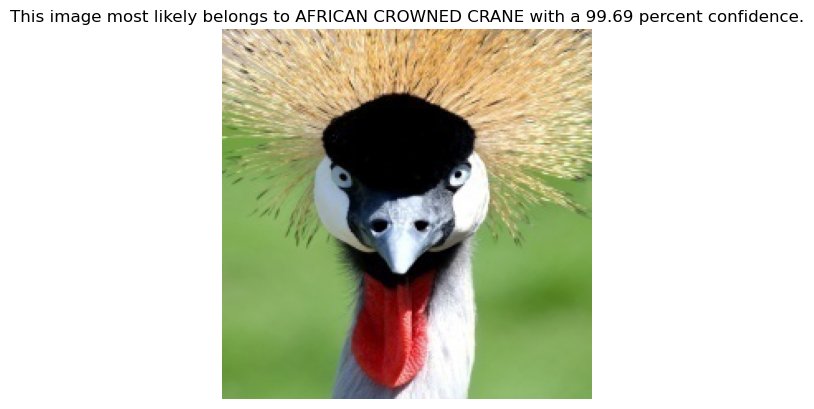

1/1 [==============================] - 0s 23ms/step


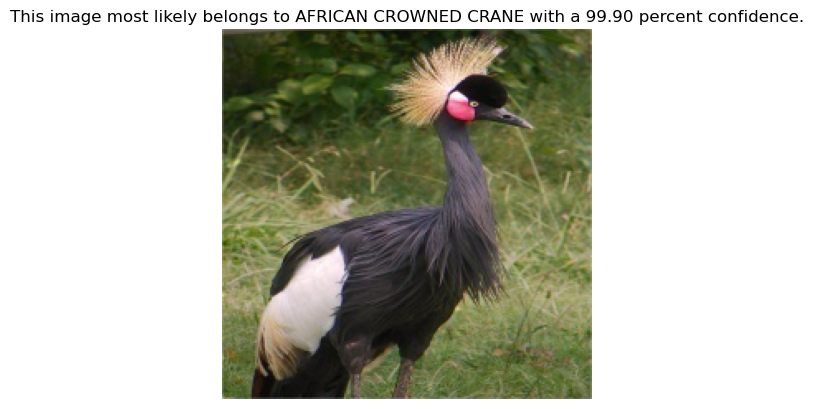

1/1 [==============================] - 0s 20ms/step


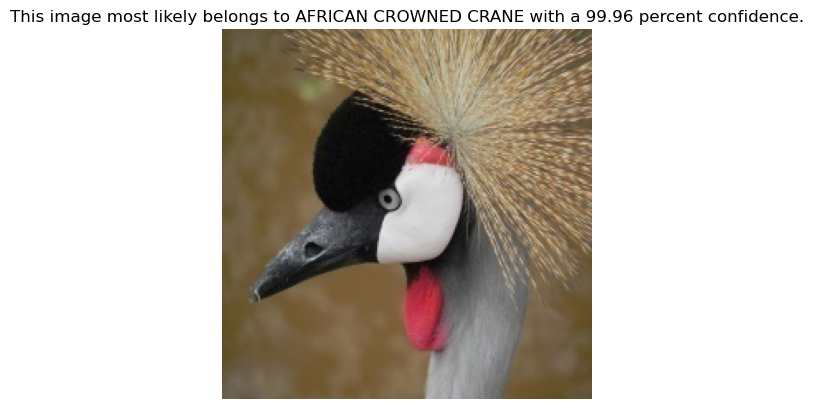

In [72]:
for img_to_predict in images_to_predict:
    image = keras.utils.load_img(img_to_predict)
    img_array = keras.utils.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)

    score = tf.nn.softmax(prediction[0])

    classification = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    
    plt.figure()
    plt.imshow(image)
    plt.title("This image most likely belongs to {} with a {:.2f} percent confidence.".format(classification,confidence))
    plt.axis('off')
    plt.show()

#### Data augmentation

In [123]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Conclusion

The results based on the pretrained model MobileNetV2 are satisfactory and predict with a high level of confidence the class of the image